In [37]:
import csv
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

options_dir = '../data/options_data'
for ticker in os.listdir(options_dir):
    ticker_dir = options_dir + '/' + ticker
    put_files = []
    for file in os.listdir(ticker_dir):
        file_heruistics = file.split('_')
        strike = file_heruistics[2].split('-', 1)
        expiry_date = datetime.strptime(file_heruistics[1], '%Y%m%d').date()

        if 'p' in strike[0].replace('.csv', ''):
            put_files.append((file, expiry_date))

    put_files.sort(key=lambda contract: contract[1])


    # implement married puts strategy
    balance = 100000
    ownUnderlying = False
    share_count = 0 # in hundreds

    csv_data = []

    for file, expiry_date in put_files:
        print(file, expiry_date)
        with open(os.path.join(ticker_dir, file), 'r') as f:
            strike_csv = csv.reader(f)
            row = list(strike_csv)
            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                    date = datetime.strptime(line[0], '%m/%d/%Y').date()
                    if date.month == expiry_date.month:
                        start_open = float(row[index][1])
                        strike_price = float(row[index][16])
                        start_price = float(row[index][15])
                        end_price = float(row[1][15])
                        break
            print(f"{start_open}, {strike_price}, {start_price}, {end_price}")
            
            puts_purchased = 0

            # if no shares are owned, buy shares and puts
            if not ownUnderlying:
                # find out how many shares and puts we can buy and purchase them
                puts_purchased = share_count = math.floor(balance / (100 * (start_open + start_price)))
                share_cost = start_price * 100 * share_count
                put_cost = start_open * 100 * share_count
                balance -= share_cost + put_cost
                ownUnderlying = True
            # else shares are owned meaning last month's puts expired 'out of the money', repurchase as many puts as we can with available balance at new strike
            # if not enough balance, sell 100 shares, check balance and buy as many puts as we can with max = share_count
            else:
                # find number of puts can buy with balance with max being the share_count
                x = min(math.floor(balance / (100*start_open)), share_count)
                while share_count and not x:
                    share_count -= 1
                    share_sale = 100 * start_price
                    balance += share_sale
                    x = min(math.floor(balance / (100*start_open)), share_count)
                    
                puts_purchased = x
                put_cost = start_open * 100 * puts_purchased
                balance -= put_cost

            # exercise puts if stock falls below strike price at EOM
            if end_price < strike_price:
                put_sale = share_count * 100 * strike_price
                balance += put_sale

                ownUnderlying = False
                share_count = 0
            
            # balance + EOM shares value = accnt value (8968 + 95376 = 104344)
            shares_value_eom = share_count * 100 * end_price
            account_value = balance + shares_value_eom
            
            # obtain 'results'
            net_percentage = ((account_value - 100000) / 100000) * 100
            net_return = account_value - 100000

            csv_data.append([expiry_date, date, strike_price, start_price, end_price, start_open, puts_purchased, account_value, balance, net_percentage, net_return])


        with open('../data/outputs/married_puts/' + ticker + '.csv', 'w+', newline="") as f:
            writer = csv.writer(f)
            header = ['Expiration Date', 'Date Put Bought', 'Strike Price', 'Starting asset price', 'Ending Asset Price', 'Price Per Put', 'Puts Bought', 'Account Value EOM', 'Cash Balance EOM', 'Percent Change', 'Profit Amount']
            variables = ['expiry_date',  'date',               'strike_price',      'start_price',            'end_price',        'start_open', 'share_count', 'account_value', 'balance', 'net_percentage', 'net_return']
            print(len(header), len(variables))
            print(header[10])
            writer.writerow(header)

            for row in csv_data:
                writer.writerow(row)

price-history-for-msft_20191129_140.00p-11-22-2021.csv 2019-11-29
1.53, 140.0, 143.72, 151.38
11 11
Profit Amount
price-history-for-msft_20191227_150.00p-11-20-2021.csv 2019-12-27
2.17, 150.0, 149.55, 158.96
11 11
Profit Amount
price-history-for-msft_20200131_155.00p-11-20-2021.csv 2020-01-31
2.48, 155.0, 160.62, 170.23
11 11
Profit Amount
price-history-for-msft_20200228_165.00p-11-22-2021.csv 2020-02-28
1.6, 165.0, 174.38, 162.01
11 11
Profit Amount
price-history-for-msft_20200327_160.00p-11-20-2021.csv 2020-03-27
5.8, 160.0, 172.79, 149.7
11 11
Profit Amount
price-history-for-msft_20200424_160.00p-11-20-2021.csv 2020-04-24
10.77, 160.0, 152.11, 174.55
11 11
Profit Amount
price-history-for-msft_20200529_170.00p-11-20-2021.csv 2020-05-29
4.1, 170.0, 174.6, 183.25
11 11
Profit Amount
price-history-for-msft_20200626_185.00p-11-20-2021.csv 2020-06-26
6.5, 185.0, 182.83, 196.33
11 11
Profit Amount
price-history-for-msft_20200731_200.00p-11-22-2021.csv 2020-07-31
6.5, 200.0, 204.7, 205.01
1

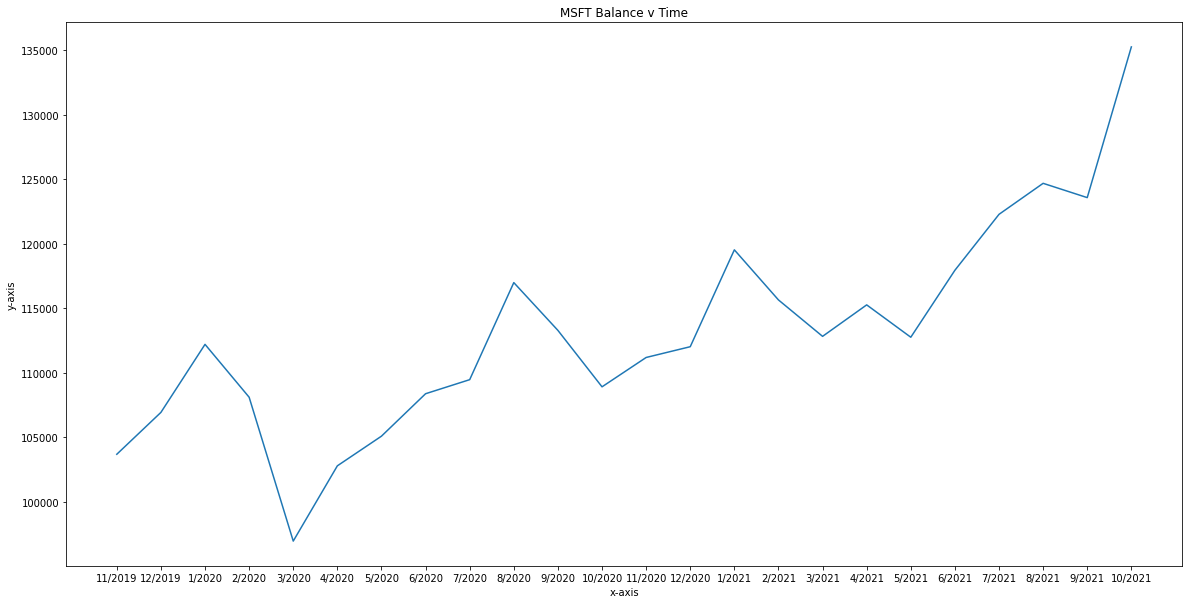

In [38]:
# graph results

outputs = '../data/outputs/married_puts/'
files = [f for f in os.listdir(outputs) if os.path.isfile(os.path.join(outputs, f))]

for file in files:
    with open(os.path.join(outputs, file), 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)

        profits = []
        monthly_balance = []
        months = []

        for line in rows[1:]:
            profits.append(round(float(line[10]), 2))
            monthly_balance.append(round(float(line[7]), 2))
            date = datetime.strptime(line[0], "%Y-%m-%d").date()
            months.append(str(date.month) + '/' + str(date.year))

        x1 = months
        y1 = monthly_balance

        return_plt = plt.figure()
        return_plt.set_figheight(10)
        return_plt.set_figwidth(20)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.title(file.replace('.csv', '') + ' Balance v Time')
        plt.plot(x1, y1)
        plt.savefig('../data/outputs/married_puts/graphs/' + file.replace('.csv', '') + '_balance_v_time.jpg')
        plt.show()